# Time series management and visualization

Veronica Andreo  
2024-07-22

## The temporal GRASS framework

GRASS was the first FOSS GIS that incorporated capabilities to *manage,
analyze, process and visualize spatio-temporal data*, as well as the
temporal relationships among time series and maps within time series.

-   The temporal GRASS framework is fully **based on metadata** and does
    not duplicate any dataset
-   It is based on a **snapshot** approach, i.e., it adds time stamps to
    maps
-   A collection of time stamped maps (snapshots) of the same variable
    are called **space-time datasets** or STDS
-   Maps in a STDS can have different spatial and temporal extents
-   Space-time datasets can be composed of raster, 3D raster or vector
    maps, and so we call them:
    -   Space time raster datasets (**STRDS**)
    -   Space time 3D raster datasets (**STR3DS**)
    -   Space time vector datasets (**STVDS**)
-   These STDS objects will then be inputs and (optionally) outputs of
    temporal tools

### How to specify time

-   Time can be defined as **intervals** (start and end time) or
    **instances** (only start time)
-   Time can be **absolute** (e.g., 2017-04-06 22:39:49) or **relative**
    (e.g., 4 years, 90 days)

### Temporal tools

GRASS temporal tools are named and organized following GRASS core naming
scheme. In this way, we have:

-   **t.\***: general tools to handle STDS of all types
-   **t.rast.\***: tools that deal with STRDS
-   **t.rast3d.\***: tools that deal with STR3DS
-   **t.vect.\***: tools that deal with STVDS

### Temporal framework and workflow

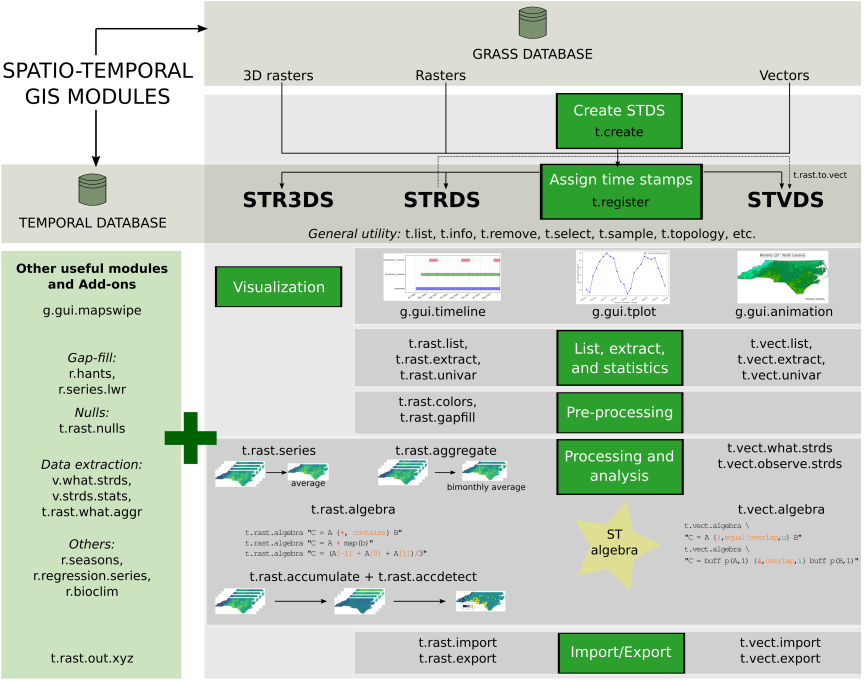

> **Setup**
>
> To run this tutorial locally or in Google Colab, you should install
> GRASS 8.4+, and download the [daily MODIS LST
> project](https://zenodo.org/doi/10.5281/zenodo.3564514). This project
> contains average daily MODIS LST (Land Surface Temperature) data
> reconstructed by [mundialis GmbH &
> Co. KG](https://www.mundialis.de/en/) based on Metz et al (2017).
>
> Follow the [Fast track to GRASS](../get_started/fast_track.qmd) and
> [GRASS in Colab](../get_started/grass_gis_in_google_colab.qmd)
> tutorials to get you started.

## Hands-on

In this first tutorial of the **“Time series in GRASS”** series, we will
learn the basics of time series management:

-   creation
-   different ways of assigning time stamps, i.e., registering
-   getting info
-   listing and selection
-   descriptive stats
-   visualizations

We begin by loading GRASS package:

In [1]:
import os
import sys
import subprocess

# Ask GRASS where its Python packages are
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)
# Import the GRASS packages we need
import grass.script as gs
import grass.jupyter as gj

Now we are ready to start a GRASS session in the downloaded project:

In [2]:
path_to_project = "italy_eu_laea/italy_LST_daily"

# Start the GRASS Session
session = gj.init(path_to_project)

### Explore the data in the mapset

Let’s first explore what we have within the `italy_LST_daily` mapset and
display a raster map using the `InteractiveMap` class from
`grass.jupyter` library.

In [3]:
# List raster elements
rast = gs.list_grouped(type="raster", pattern="lst*")['italy_LST_daily']
rast[0:10]

In [4]:
# Display raster map with interactive class
lst_map = gj.InteractiveMap(use_region=True, tiles="CartoDB.DarkMatter")
lst_map.add_raster("lst_2014.005_avg")
lst_map.show()

### Create a time series

When working with the temporal framework, the first step is to create
the time series object or STDS. This object is basically a container for
maps that are already imported into or linked to our GRASS project, we
are not duplicating any data. It consists of a SQLite table that will
then store map names and metadata such as spatial extent, temporal
extent, min and max values, semantic labels, etc.

To create the time series object, we use
[t.create](https://grass.osgeo.org/grass-stable/manuals/t.create.html)
and we need to define the type (strds, stvds or st3ds), the temporal
type (absolute or relative), the output or name of the time series
object, a title and a description.

In [5]:
# Create time series 
gs.run_command("t.create",
               type="strds",
               temporaltype="absolute",
               output="lst_daily",
               title="Average Daily LST",
               description="Gap filled average daily MODIS LST in Celsius - 2014-2018")

With [t.list](https://grass.osgeo.org/grass-stable/manuals/t.list.html)
we check the object was indeed created and with
[t.info](https://grass.osgeo.org/grass-stable/manuals/t.info.html) we
can explore details about this recently created object.

In [6]:
# Check it is created
gs.run_command("t.list",
              type="strds")

In [7]:
# Check time series metadata
print(gs.read_command("t.info",
                      input="lst_daily"))

Since we have not yet registered our LST maps in the time series object,
it is empty, i.e., there is no metadata to show.

### Assign time stamps: register maps

To actually fill our time series object with the LST maps, we need to
assign time stamps to these maps. For this we use the
[t.register](https://grass.osgeo.org/grass-stable/manuals/t.register.html)
tool. There are different ways of registering maps. We can either pass a
sorted list of maps or a text file with one map per line and optionally
start and end dates, and semantic labels. It is also important to
understand if our data represent time intervals (e.g. precipitation over
a period of time) or time instances (events), and in the case of
intervals, if they are regular (e.g., monthly) or irregular, as all
these will determine different `t.register` usage possibilities.

Here, we will exemplify the use of a list of maps and, since our data
represent regular time intervals, we will use the start and increment
options together with the `i` flag to actually create the intervals.

In [8]:
# Get list of maps and print the first 5 elements 
map_list = gs.list_grouped(type="raster", pattern="lst_201*")['italy_LST_daily']
map_list[0:6]

In [9]:
# How many maps do we have?
len(map_list)

In [10]:
# Register maps in strds  
gs.run_command("t.register", 
               input="lst_daily",
               maps=map_list,
               increment="1 days",
               start="2014-01-01", 
               flags="i")

Let’s check the metadata once again, all fields should be populated now.

In [11]:
# Get info about the strds
print(gs.read_command("t.info",
                      input="lst_daily",
                      flags="g"))

The tool `t.info` can also provide information of single maps, e.g.:

In [12]:
# Get info about a map within the strds
gs.run_command("t.info", 
               input="lst_2014.005_avg", 
               type="raster")

> **Note**
>
> Compare with the output of `r.info map=lst_2014.005_avg`.

#### Different ways of registering maps

According to the data you are working with, there might be different
options to properly register the data within time series objects. The
case presented above is one of the easiest, i.e., data represents
regular intervals. So, `start`, `increment` and `i` did it.

Let’s suppose however, we now work with the so called 8-day or 16-day
products. These also represent interval time, but the last map of each
year has a different granularity. This is because the aggregation cycle
restarts every January 1st, and also because we have leap years. In this
case, the option `increment="8 days"` will give wrong results. The
solution is to create a text file containing map name, start and end
time, and pass it with the `file` option.

Luckily, this can be done programmatically. Indeed, most data file names
come with some indication of date that we can use to create our file.
See for example this [small python
script](https://grasswiki.osgeo.org/wiki/Temporal_data_processing#Creating_a_STRDS_and_registering_maps)
or the shell example within
[t.rast.aggregate.ds](https://grass.osgeo.org/grass-stable/manuals/t.rast.aggregate.ds.html#modis-satellite-sensor-daily-data-aggregation-to-8-days)
manual. Furthermore, tools such as
[i.modis.import](https://grass.osgeo.org/grass-stable/manuals/addons/i.modis.import.html)
will create the registration file for you after importing products into
GRASS GIS.

A similar case occurs when handling imagery data. Usually, they
represent time instances (not intervals, i.e., no end date). Hence, to
register imagery data, we might also need to create a text file. In this
case, with map names and start time only. Tools like
[i.sentinel.import](https://grass.osgeo.org/grass-stable/manuals/addons/i.sentinel.import.html)
or
[i.landsat.import](https://grass.osgeo.org/grass-stable/manuals/addons/i.landsat.import.html)
can create this file for you when you import data into GRASS GIS.

> **Note**
>
> Have a look at the
> <a href="https://grass.osgeo.org/grass83/manuals/t.register.html">t.register</a>
> manual page and a dedicated
> [wiki](https://grasswiki.osgeo.org/wiki/Temporal_data_processing/maps_registration)
> with further examples.

### Time series visualization

There are different tools for time series visualization in GRASS. In
this tutorial, we will explore those within the Graphical User Interface
(GUI).

#### Timeline plot

The timeline plot,
[`g.gui.timeline`](https://grass.osgeo.org/grass-stable/manuals/g.gui.timeline.html),
is a graphic visualization of the temporal and (optionally) spatial
granularity and extent of a STDS. It is very useful to compare
granularities and observe topological relationships among STDS.

In [13]:
!g.gui.timeline inputs=lst_daily

<figure>
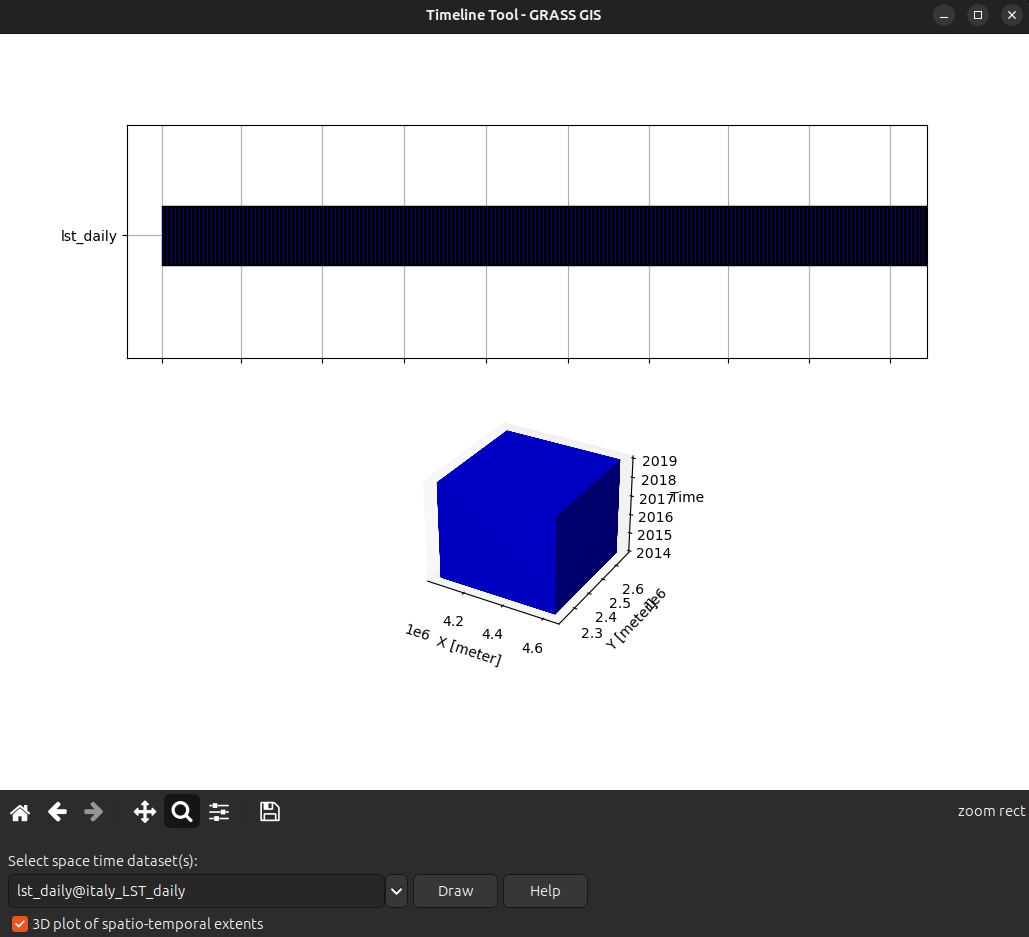
<figcaption aria-hidden="true">g.gui.timeline output</figcaption>
</figure>

#### Temporal plot for Trento, Italy

The temporal plot tool,
[`g.gui.tplot`](https://grass.osgeo.org/grass83/manuals/g.gui.tplot.html),
allows to plot the time series values of raster or vector space-time
datasets. In this case, we will plot the LST time series for the city of
Trento, Italy. In the graphical interface of `g.gui.tplot`, the point
coordinates can be typed directly, copied from the map or selected
interactively in the *map display*.

In [14]:
# LST time series plot for Trento city center
!g.gui.tplot strds=lst_daily coordinates=4410837.455830389,2559852.473498233 title="Trento daily LST" xlabel="Time" ylabel="LST (C)" size=800,500 output=trento.png 

<figure>
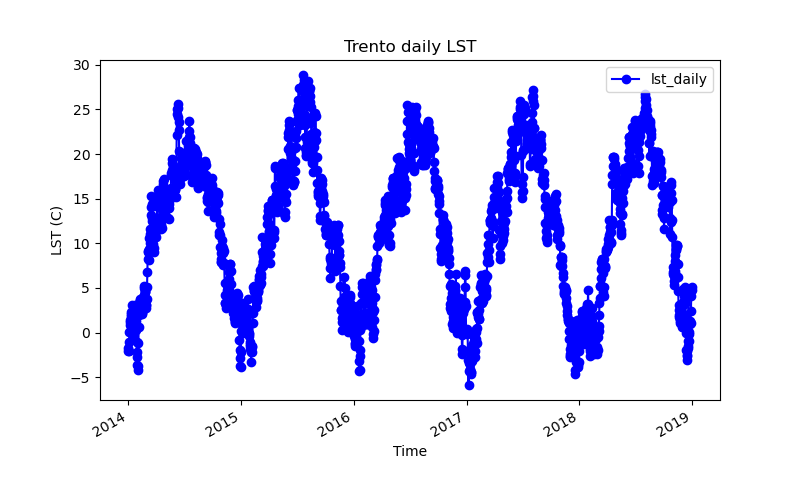
<figcaption aria-hidden="true">g.gui.tplot output</figcaption>
</figure>

If instead you want to query and plot time series of several points in a
vector map, you might want to check
[t.rast.what](https://grass.osgeo.org/grass-stable/manuals/t.rast.what.html).

In [15]:
gs.run_command("v.random", 
               output="random_points",
               npoints=5,
               seed=54)
gs.run_command("t.rast.what",
               points="random_points",
               strds="lst_daily",
               where="start_time >= '2018-09-30'",
               layout="col",
               flags="n")

### Lists and filtering

There are different tools dedicated to listing within the temporal
framework:

-   [t.list](https://grass.osgeo.org/grass-stable/manuals/t.list.html)
    to list STDS and maps registered within the temporal database
    whether they belong to a STDS or not,
-   [t.rast.list](https://grass.osgeo.org/grass-stable/manuals/t.rast.list.html)
    for maps in raster time series, and
-   [t.vect.list](https://grass.osgeo.org/grass-stable/manuals/t.vect.list.html)
    for maps in vector time series.

The variables that can be used to perform listing and filtering differ
among raster and vector time series:

-   STRDS: id, name, creator, mapset, temporal_type, creation_time,
    start_time, end_time, north, south, west, east, nsres, ewres, cols,
    rows, number_of_cells, min, max.
-   STVDS: id, name, layer, creator, mapset, temporal_type,
    creation_time, start_time, end_time, north, south, west, east,
    points, lines, boundaries, centroids, faces, kernels, primitives,
    nodes, areas, islands, holes, volumes.

Let’s see some listing examples:

In [16]:
# Check list of STRDS in the mapset
print(gs.read_command("t.list", 
                      type="strds"))

In [17]:
# Check raster maps in the temporal database
print(gs.read_command("t.list", 
                      type="raster",
                      where="start_time >= '2018-06-30'"))

With the Python Pandas package we can simply read in the output of
*t.rast.list* as a DataFrame:

In [18]:
import pandas as pd

# Check the list of maps in the STRDS
pd.DataFrame(gs.parse_command("t.rast.list", input="lst_daily", format="csv"))

In [19]:
# Check min and max per map
pd.DataFrame(gs.parse_command("t.rast.list",
                              input="lst_daily",
                              columns="name,min,max",
                              format="csv"))

In [20]:
# Maps with minimum value lower than or equal to 10
pd.DataFrame(gs.parse_command("t.rast.list",
                              input="lst_daily",
                              order="min", 
                              columns="name,start_time,min",
                              where="min <= '10.0'",
                              format="csv"))

In [21]:
# Maps with maximum value higher than 30
pd.DataFrame(gs.parse_command("t.rast.list",
                              input="lst_daily",
                              order="max",
                              columns="name,start_time,max",
                              where="max > '30.0'",
                              format="csv"))

In [22]:
# Maps between two given dates
pd.DataFrame(gs.parse_command("t.rast.list",
                              input="lst_daily",
                              columns="name,start_time",
                              where="start_time >= '2015-05' and start_time <= '2015-08-01 00:00:00'",
                              format="csv"))

In [23]:
# Maps from January
pd.DataFrame(gs.parse_command("t.rast.list",
                              input="lst_daily",
                              columns="name,start_time",
                              where="strftime('%m', start_time)='01'",
                              format="csv"))

Most tools within the temporal framework have the `where` option. So,
the same filtering can be applied in tools to determine maps that will
be processed.

### Descriptive statistics

The tool
[`t.rast.univar`](https://grass.osgeo.org/grass-stable/manuals/t.vect.univar.html)
calculates univariate statistics from the non-null cells of each raster
map within STRDS. By default it returns the name of the map, the start
and end date of the dataset and the following values: mean, minimum and
maximum value, mean_of_abs, standard deviation, variance, coeff_var,
number of null cells, total number of cells.

In [24]:
# Print univariate stats for maps within STRDS
print(gs.read_command("t.rast.univar",
                      input="lst_daily",
                      nprocs=6))

Using the `e` flag it can calculate also extended statistics and the
output can be saved in a text file to be read elsewhere.

In [25]:
# Write extended univariate stats output to a csv file
gs.run_command("t.rast.univar",
               flags="e",
               input="lst_daily",
               output="ext_stats_lst_daily.csv",
               separator="comma",
               nprocs=6)

The Python pandas package allows us to read this file and then make
plots.

In [26]:
# Read the csv and plot
lst = pd.read_csv("ext_stats_lst_daily.csv", usecols=[2, 4, 5, 6])
lst['start'] = pd.to_datetime(lst.start, format="%Y-%m-%d", exact=False)
lst

Let’s have a look at the plot:

In [27]:
lst.plot.line(0, [1,2,3], subplots=False);

## References

-   Metz, M., Andreo, V., Neteler, M. 2017. *A New Fully Gap-Free Time
    Series of Land Surface Temperature from MODIS LST Data.* Remote
    Sensing 9(12), 1333. [DOI](https://doi.org/10.3390/rs9121333).
-   Gebbert, S., Pebesma, E. 2014. *TGRASS: A temporal GIS for field
    based environmental modeling.* Environmental Modelling & Software
    53, 1-12. [DOI](http://dx.doi.org/10.1016/j.envsoft.2013.11.001).
-   Gebbert, S., Pebesma, E. 2017. *The GRASS GIS temporal framework.*
    International Journal of Geographical Information Science 31,
    1273-1292. [DOI](http://dx.doi.org/10.1080/13658816.2017.1306862).
-   [Temporal data
    processing](https://grasswiki.osgeo.org/wiki/Temporal_data_processing)
    wiki page.

------------------------------------------------------------------------

The development of this tutorial was funded by the US [National Science
Foundation (NSF)](https://www.nsf.gov/), award
[2303651](https://www.nsf.gov/awardsearch/showAward?AWD_ID=2303651).